# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Loading Data
The input data are 4 cameras each with a x and y coordinate of where the ball is in the camera's frame. The output data is the x, y and z coordinate of the ball in the 3d space.
To get the input data from the recordings I used the following notebook: ../DataProcessing/StoreDataOfAllRecordings.ipynb

In the input data I recorded the following trajectories:
- Buttefly motion
- Spiral motino
- Spirograph motion

In [2]:
X = pd.read_csv('../data-4cams/all/red_ball_all_4cams.csv', decimal='.', delimiter=',')
y = pd.read_csv('../data-4cams/all/positions_xyz_all_4cams.csv', decimal='.', delimiter=',')
X.shape, y.shape

((7495, 8), (7495, 3))

## 3. Preprocessing

In [3]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter tuning

In [4]:
pipeline = Pipeline([
    ('mlp', MLPRegressor())
])

In [5]:
param_grid = {
    'mlp__hidden_layer_sizes': [(10,), (50, 30), (100, 50), (20, 10, 5)],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

### 4.1 Training

In [6]:
random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
13 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('mlp', MLPRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(10,),
                                                                    (50, 30),
                                                                    (100, 50),
                                                                    (20, 10,
                                                                     5)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=2)

### 4.2 Best parameters

In [7]:
print(f'Best parameters: {random_search.best_params_}')

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 20000, 'mlp__learning_rate_init': 0.1, 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (50, 30), 'mlp__early_stopping': True, 'mlp__alpha': 0.001, 'mlp__activation': 'identity'}


In [8]:
print(f'Best score: {random_search.best_score_}')

Best score: 0.5248131255366822


## 5. Training the model

In [9]:
model = random_search.best_estimator_

In [10]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(activation='identity', alpha=0.001,
                              early_stopping=True, hidden_layer_sizes=(50, 30),
                              learning_rate_init=0.1, max_iter=20000))])

## 6. Make predictions on new data
The trajectories that I used to train the model are the following:
- 8 motion

### 6.1 Load new data

In [11]:
X_test_8 = pd.read_csv('../data-4cams/data-8/red_ball_coordinates_128px_2024-03-08_14h44m.csv', decimal='.', delimiter=',')
y_test_8 = pd.read_csv('../data-4cams/data-8/positions_xyz_2024-03-08_14h44m.csv', decimal='.', delimiter=',').iloc[4:]

### 6.2 Preprocessing
This method is used to prepare the data for the model. It scales the input data and drops the NaN values from the output data.

In [12]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test):
    y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :8]
    y_val = combined_test.iloc[:, 8:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [13]:
X_scaled_test_8, y_test_8 = prepare_and_scale_test_data(X_test_8, y_test_8, scaler_X)

### 6.3 Make predictions evaluate and visualize
This method is used to make predictions on the test data, then it evaluates the model using the mean squared error, mean absolute error and the r2 score. Finally, it visualizes the predicted and the actual trajectory of the ball in a 3d space.

In [14]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

Mean Squared Error on Test Data Set: 0.34496241279234735
Mean Absolute Error on Test Data Set: 0.4735032511809862
R2 Score on Test Data set: 0.7279404480436624


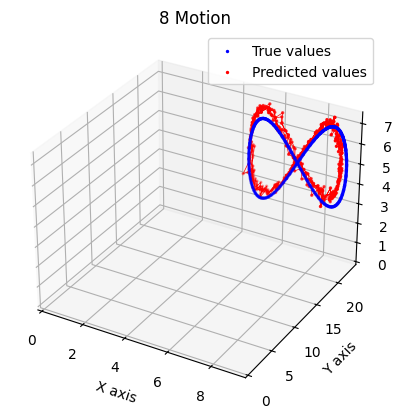

In [15]:
y_test_8_pred, mse_8, mae_8, r2_8 = predict_evaluate_plot(X_scaled_test_8, y_test_8, model, scaler_y, '8 Motion')